In [43]:
from datetime import date, timedelta

from featureeng.times import get_trading_times_for_london_ny
from featureeng.features import *
import featureeng as feng
import data.readers as rd
import joblib


import matplotlib.pyplot as plt

import multiprocessing
import time
import threading
import json
import os

import pyarrow as pa
import pyarrow.parquet as pq

# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifier/Regressor
from xgboost import XGBClassifier

# Feature selection
from BorutaShap import BorutaShap

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.mixture import GaussianMixture

import pickle
# Validation
from sklearn.model_selection import StratifiedKFold

#helper functions
from datetime import date, timedelta

from featureeng.times import get_trading_times_for_london_ny
from featureeng.features import *
import featureeng as feng
import data.readers as rd

import multiprocessing
import time
import threading
import json
import os

import pyarrow as pa
import pyarrow.parquet as pq

# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifier/Regressor
from xgboost import XGBClassifier

# Feature selection
from BorutaShap import BorutaShap

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.mixture import GaussianMixture

import pickle
# Validation
from sklearn.model_selection import StratifiedKFold

root_dir = '/home/dcai/data/features'
instrument='EURCHF'
feature_set="2"



temp_save_dir="{}/{}".format(root_dir,instrument)

def save_df(save_dir, df, name):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    pq.write_table(pa.Table.from_pandas(df), os.path.join(save_dir, name))


temp_save_dir="{}/{}".format(root_dir,instrument)
def read_parquet(save_dir, name):
    return pq.ParquetFile(os.path.join(save_dir, name)).read().to_pandas()



def list_of_files(root_dir):
    filenames = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            # Check if the file is a CSV file
            if file.endswith('.parquet'):
                filenames.append(os.path.join(root, file))
    return filenames

def read_in_files(file_list):
    dfs = []
    for f in file_list:
        dfs.append(pq.ParquetFile(f).read().to_pandas())
    return pd.concat(dfs).sort_index()

def train_valid_test(instrument, feature_set, root_dir='/home/dcai/data/features',  train_size=0.75):
    files = list_of_files("{}/{}/{}".format(root_dir,instrument, feature_set))
    files.sort()

    train_index = int(len(files)*train_size)
    train = files[0:train_index]
    valid_test = files[train_index:]


    valid = valid_test[0::2]
    test = valid_test[1::2]

    return {'train': read_in_files(train),
            'valid': read_in_files(valid),
            'test': read_in_files(test)
           }

def extract_features_from_gmm_cols(gmm_cols):
    result = [splits[0] for string in gmm_cols for splits in [string.split("_gmm_")] if len(splits) > 1]
    return list(set(result))


root_dir = '/home/dcai/data/features'
instrument='EURCHF'
feature_set="2"



temp_save_dir="{}/{}".format(root_dir,instrument)

def save_df(save_dir, df, name):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    pq.write_table(pa.Table.from_pandas(df), os.path.join(save_dir, name))



def read_parquet(save_dir, name):
    return pq.ParquetFile(os.path.join(save_dir, name)).read().to_pandas()


with open(os.path.join(temp_save_dir, 'y_stratified.pickle'), 'rb') as f:
    y_stratified = pickle.load(f)

    


#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()    
    
    
def read_pickle(path, file_name):
    with open(os.path.join(path, file_name), 'rb') as f:
        return pickle.load(f)
    
def load_booster(model_file):
    return joblib.load(os.path.join(temp_save_dir, model_file))

def load_model(model_file):
    booster = load_booster(model_file)
    clf = XGBClassifier()

    # Load the XGBoost model into the wrapper using the load_model method
    clf._Booster = booster
    return clf

In [10]:
trainX = read_parquet(temp_save_dir, "trainX.parqet")
trainY = read_pickle(temp_save_dir, "trainY.pickle")

validateX = read_parquet(temp_save_dir, "validateX.parqet")
validateY = read_pickle(temp_save_dir, "validateY.pickle")

testX = read_parquet(temp_save_dir, "testX.parqet")
testY = read_pickle(temp_save_dir, "testY.pickle")


In [11]:

import xgboost as xgb

dtest = xgb.DMatrix(testX, testY, enable_categorical=False)

In [41]:
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import EnsembleVoteClassifier


model1=load_model('xgb-2.joblib')
model2=load_model('xgb-3.joblib')
model3=load_model('xgb-4.joblib')

In [25]:
models = [('model1', model1), ('model2', model2), ('model3', model3)]

# create a VotingClassifier using hard voting
voting_clf = VotingClassifier(estimators=models, voting='hard')

# create an EnsembleVoteClassifier using hard voting
ensemble_clf = EnsembleVoteClassifier(clfs=[model1, model2, model3], voting='hard')

# fit the VotingClassifier and EnsembleVoteClassifier to your data
voting_clf.fit(trainX, trainY)
ensemble_clf.fit(trainX, trainY)

# predict with the VotingClassifier and EnsembleVoteClassifier
voting_pred = voting_clf.predict(testX)
ensemble_pred = ensemble_clf.predict(testX)

In [26]:
from sklearn.metrics import accuracy_score, f1_score


print('-- Model Report voting_clf --')
print('XGBoost Accuracy: '+str(accuracy_score(voting_pred, testY)))
print('XGBoost F1-Score (Micro): '+str(f1_score(voting_pred,testY,average='micro')))


print('-- Model Report ensemble_clf --')
print('XGBoost Accuracy: '+str(accuracy_score(ensemble_pred, testY)))
print('XGBoost F1-Score (Micro): '+str(f1_score(ensemble_pred,testY,average='micro')))

-- Model Report voting_clf --
XGBoost Accuracy: 0.5690412885934992
XGBoost F1-Score (Micro): 0.5690412885934992
-- Model Report ensemble_clf --
XGBoost Accuracy: 0.5690412885934992
XGBoost F1-Score (Micro): 0.5690412885934992


In [40]:
print(testX.shape)
print(testY.shape)

(2114119, 121)
(2114119,)


In [ ]:
dtest = xgb.DMatrix(testX, testY, enable_categorical=False)


model1  = load_booster('xgb-2.joblib')
model2  = load_booster('xgb-3.joblib')
model3  = load_booster('xgb-4.joblib')

(2114119, 3)
(2114119,)
-- Model Report ensemble_clf --
XGBoost Accuracy: 0.6192376115062587
XGBoost F1-Score (Micro): 0.6192376115062587


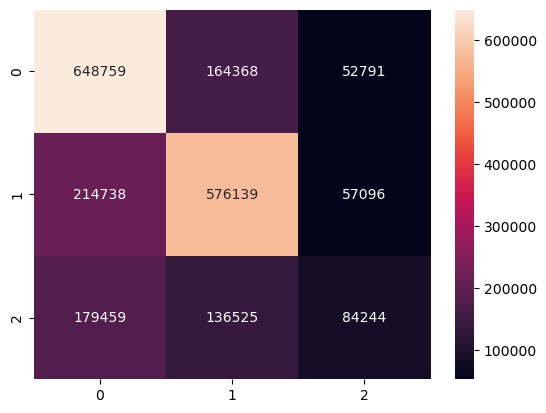

In [55]:
from sklearn.metrics import confusion_matrix
import pylab as pl

import seaborn as sns
import matplotlib.pyplot as plt    

# Predict probabilities for each class
prob1 = model1.predict(dtest)
prob2 = model2.predict(dtest)
prob3 = model3.predict(dtest)
print(prob1.shape)

ensemble_prob2 = np.average([prob1, prob2, prob3], axis=0)

ensemble_pred2 = ensemble_prob2.argmax(axis=1)


print(ensemble_pred2.shape)

print('-- Model Report ensemble_clf --')
print('XGBoost Accuracy: '+str(accuracy_score(ensemble_pred2, testY)))
print('XGBoost F1-Score (Micro): '+str(f1_score(ensemble_pred2,testY,average='micro')))

 

cm = confusion_matrix(testY, ensemble_pred2)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation



